## Computer Vision

# Project 03

### Training

#### Import libraries

In [2]:
import os
import time
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dropout, Dense
from keras.models import Model, Sequential

#### Create train and test dataset

In [3]:
def read_csv(dataset_type,i):
    n = ""
    if i < 10:
        n = "0" + str(i)
    else:
        n = str(i)
    to_home = '../../../../'
    dataset_path = 'Multimedia/Datasets/Human Actions/Dataset/'
    file_path = 'Video_' + n + '/Video_' + n + '_' + dataset_type + '.csv'
    dataset_info_file = to_home + dataset_path + file_path
    df = pd.read_csv(dataset_info_file)
    return df
    
def create_datasets(dataset_type,test_video):
    df_train = pd.DataFrame()
    df_test  = pd.DataFrame()
    for i in range(1,6):
        if i == test_video:
            df_test = df_test.append(read_csv(dataset_type,i))
        else:
            df_train = df_train.append(read_csv(dataset_type,i))
    return df_train, df_test

In [4]:
dataset_type = 'gray'
test_video = 5
df_train, df_test = create_datasets(dataset_type,test_video)

#### Create TRAIN and TEST sets

1. Create two categories, *Non violence behavior* and *Violence behavior*.

2. Create a list of sequences with a timestep of 10.

In [5]:
def func(df):
    path_to_folder = '../../../../Multimedia/Datasets/Human Actions/'
    X = []
    y = []
    for i, filename in enumerate(df['Image path']):
        image = cv.imread(path_to_folder+filename)
        X.append(image)
        image_category = df['Category'].iloc[i]
        if image_category == 'conversation' \
        or image_category == 'draw attention' \
        or image_category == 'handshake' \
        or image_category == 'help stand-up' \
        or image_category == 'help walk' \
        or image_category == 'hug' \
        or image_category == 'nothing' \
        or image_category == 'stand by':
            y.append(0)
        elif image_category == 'fight' \
        or image_category == 'push':
            y.append(1)
    X = np.array(X)
    y = np.array(y)
    X = X.astype('float32')
    X = X/255
    
    total_samples,rows,columns,channels = X.shape
    print('total samples:',total_samples)
    
    timestep = 10
    samples = round(total_samples/timestep)

    X_ = np.zeros((samples,timestep,rows,columns,channels))
    y_ = np.zeros((samples,2))
    
    print('samples:      ',samples)
    print('timestep:     ',timestep)
    print('rows:         ',rows)
    print('columns:      ',columns)
    print('channels:     ',channels)
    print('')

    violence_threshold = 1
    k = 0
    for i in range(samples):
        l = 0
        for j in range(timestep):
            if k < total_samples:
                X_[i,j,:,:,:] = X[k,:,:,:]
                l += y[k]
                k += 1
        if l > violence_threshold:
            y_[i] = [0,1]
        else:
            y_[i] = [1,0]
    return X_,y_

In [6]:
print('Train set')
X_train,y_train = func(df_train)
print('Test set')
X_test,y_test = func(df_test)

samples,timestep,rows,columns,channels = X_train.shape

Train set
total samples: 5012
samples:       501
timestep:      10
rows:          108
columns:       192
channels:      3

Test set
total samples: 1546
samples:       155
timestep:      10
rows:          108
columns:       192
channels:      3



#### Create model

Create a CNN-LSTM model.

In [8]:
def Modelo():
    # define CNN model
    inputs  = Input(shape=(timestep,rows,columns,channels),ragged=True)
    cnn     = TimeDistributed(Conv2D(1,(3,3),activation='relu',padding='same',))(inputs)
    cnn     = TimeDistributed(MaxPooling2D(pool_size=(3,3)))(cnn)
    cnn     = TimeDistributed(Flatten())(cnn)
    # define LSTM model
    lstm    = LSTM(100)(cnn)
    lstm    = Dropout(0.5)(lstm)
    lstm    = Dense(100,activation='relu')(lstm)
    outputs = Dense(y_train.shape[1],activation='softmax')(lstm)
    model = Model(inputs,outputs)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

model = Modelo()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 108, 192, 3)  0         
                             ]                                   
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 108, 192, 1)  28        
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 36, 64, 1)    0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 10, 2304)         0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 100)               9620

Show model and save image.

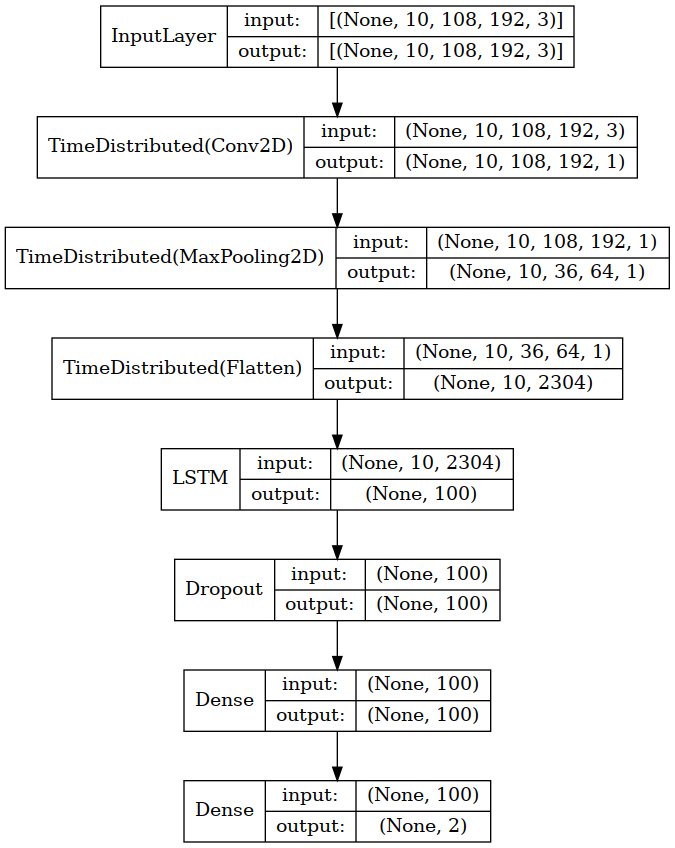

In [9]:
tf.keras.utils.plot_model(model,to_file='CNN-LSTM_model.png',show_shapes=True,show_layer_names=False)

### Training

Create a function to train, evaluate and show execution time.

In [10]:
def Model_log(model,batch_size,num_epoch):
    start = time.time()
    model_log = model.fit(X_train,y_train,
              batch_size=batch_size,
              epochs=num_epoch,
              verbose=0,
              validation_data=(X_test,y_test))
    _, acc = model.evaluate(X_test,y_test,verbose=0)
    print("accuracy: > %.3f" % (acc * 100.0))
    end = time.time()
    m = (end - start)/60
    m = round(m, 2)
    s = (end - start)
    s = round(s, 2)
    print(f"Training time: {m} min / {s} sec")
    return model_log

Create a function to plot the results.

In [11]:
def plot_model_log(model_log):
    fig = plt.figure()
    
    plt.subplot(2,1,1)
    plt.plot(model_log.history['accuracy'])
    plt.plot(model_log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.grid(color='b', linestyle='-', linewidth=0.25)

    plt.subplot(2,1,2)
    plt.plot(model_log.history['loss'])
    plt.plot(model_log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.grid(color='b', linestyle='-', linewidth=0.25)

    plt.tight_layout()
    plt.show()

#### Compute the model

1. Compute the model.

2. Plot the results.

3. Save model.

accuracy: > 75.484
Training time: 0.78 min / 46.59 sec


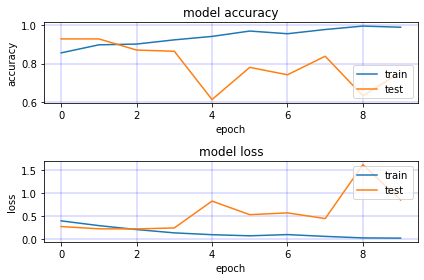

In [12]:
model_log = Model_log(model,batch_size=32,num_epoch=10)
plot_model_log(model_log)
model.save("CNN_LSTM.h5")

## Compute Model with GoDec preprocessed dataset

#### Create train and test dataset

In [13]:
dataset_type = 'godec'
test_video = 5
df_train, df_test = create_datasets(dataset_type,test_video)

#### Create TRAIN and TEST sets

In [14]:
print('Train set')
X_train,y_train = func(df_train)
print('Test set')
X_test,y_test = func(df_test)

samples,timestep,rows,columns,channels = X_train.shape

Train set
total samples: 5012
samples:       501
timestep:      10
rows:          108
columns:       192
channels:      3

Test set
total samples: 1546
samples:       155
timestep:      10
rows:          108
columns:       192
channels:      3



#### Compute the model

accuracy: > 87.097
Training time: 0.73 min / 43.97 sec


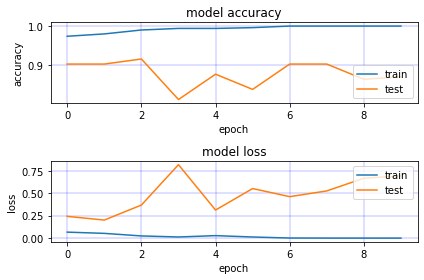

In [15]:
model_log = Model_log(model,batch_size=32,num_epoch=10)
plot_model_log(model_log)
model.save("CNN_LSTM_GoDec.h5")